<a href="https://colab.research.google.com/github/Yohan0358/Study_GAN/blob/main/CGAN(210717).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CGAN
- Conditional GAN

![](https://blog.kakaocdn.net/dn/CMYPe/btqxj0G4Nh4/rzWRFS0zw54Lh1MyhZ47AK/img.png)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
class Custom_dataset(Dataset):
    def __init__(self, dataset, transform = None):
        super(Custom_dataset, self).__init__()
        '''
        csv file
        '''
        self.images = dataset.iloc[:, 1:].to_numpy().astype('uint8').reshape(-1, 28, 28)
        self.labels = dataset.iloc[:, 0].values
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
batch_size = 64

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5), std=(0.5))
                                ])

# data = datasets.MNIST('./MNIST', 
#                 train = True, 
#                 transform = transform, 
#                 download = True)

sample_mnist = pd.read_csv('/content/sample_data/mnist_train_small.csv')
data = Custom_dataset(sample_mnist, transform = transform)

loader = DataLoader(data, batch_size = batch_size, shuffle= True)

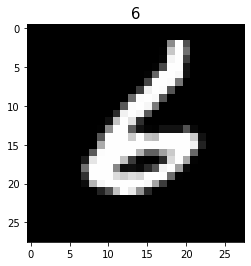

In [5]:
# Check data
sample_img, sample_label = next(iter(loader))
plt.imshow(sample_img[0][0], cmap = 'gray')
plt.title(sample_label[0].item(), fontsize = 15)
plt.show()

In [6]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.01)
        nn.init.constant_(m.bias.data, 0)

In [7]:
'''
GAN model
'''
class Descriminator(nn.Module):
    def __init__(self, image_size, n_classes = 10):
        super(Descriminator, self).__init__()

        self.main = nn.Sequential(
            self._block(image_size**2 + n_classes, 256),
            self._block(256, 512),
            self._block(512, 256),
            nn.Linear(256, 1),
            # nn.Sigmoid()     # LSGAN
        )

        self.label_emb = nn.Embedding(10, 10)
        
    def _block(self, in_ch, out_ch):
        return nn.Sequential(
        nn.Linear(in_ch, out_ch),
        nn.Dropout(0.2), 
        nn.LeakyReLU(0.1))
    
    # def one_hot(self, labels):
    #     v = torch.zeros(len(labels), 10)
    #     v[range(len(labels)), labels] = 1
    #     return v
    
    def forward(self, x, labels):
        x = x.view(-1, 28 * 28)
#         labels_v = self.one_hot(labels)
        labels_v = self.label_emb(labels)
        x = torch.cat([x, labels_v], dim = 1)  
        x = self.main(x)
        return x.squeeze()


class Generator(nn.Module):
    def __init__(self, latent, n_classes = 10, image_size = 28):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            self._block(latent + n_classes, 256),
            self._block(256, 512),
            self._block(512, 1024),
            nn.Linear(1024, image_size ** 2),
            nn.Tanh()
        )
        
        self.label_emb = nn.Embedding(10, n_classes)

        
    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Linear(in_ch, out_ch),
            nn.Dropout(0.2), 
            nn.LeakyReLU(0.1))

    # def one_hot(self, labels):
    #     v = torch.zeros(len(labels), 10)
    #     v[range(len(labels)), labels] = 1
    #     return v        
            
    def forward(self, x, labels):
#         label_v = self.one_hot(labels)
        labels_v = self.label_emb(labels)
        x = torch.cat([x, labels_v], dim = 1)
        x = self.main(x)
        return x

         
def test():
    labels = torch.randint(0, 10, (16,))
    z = torch.randn(16, 100)
    G = Generator(latent = z.size(-1))
    D = Descriminator(28)
    output = D((G(z, labels)), labels)

    print(output.shape)

test()

torch.Size([16])


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device :', device)

# hyperparameters

lr = 1e-4
latent = 100
image_size = 28
epochs = 50

G = Generator(latent).to(device)
D = Descriminator(image_size).to(device)
weight_init(G)
weight_init(D)

G_optim = optim.Adam(G.parameters(), lr = lr)
D_optim = optim.Adam(D.parameters(), lr = lr)

criterion = nn.MSELoss()
# criterion = nn.BCELoss()

device : cuda


In [23]:
def generate_noise(batch_size = batch_size, latent = latent):
    z = torch.randn(batch_size, latent)
    return z

def grid_imshow(img, nrow = 5):
    img = make_grid(output.cpu().detach().reshape(-1, 1, 28, 28), nrow = nrow)
    img = (img + 1) / 2 
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

[1/50] epochs 	D loss : 0.0991 	G loss : 1.0247
[2/50] epochs 	D loss : 0.0983 	G loss : 1.1438
[3/50] epochs 	D loss : 0.1346 	G loss : 0.9416
[4/50] epochs 	D loss : 0.1353 	G loss : 0.9486
[5/50] epochs 	D loss : 0.1244 	G loss : 0.9346
[6/50] epochs 	D loss : 0.1285 	G loss : 0.9202
[7/50] epochs 	D loss : 0.1024 	G loss : 0.9441
[8/50] epochs 	D loss : 0.0900 	G loss : 0.9917
[9/50] epochs 	D loss : 0.1144 	G loss : 0.9270
[10/50] epochs 	D loss : 0.1042 	G loss : 0.9460


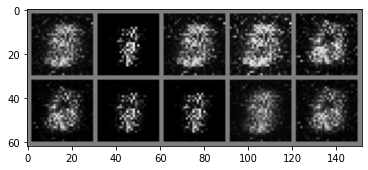

[11/50] epochs 	D loss : 0.1172 	G loss : 0.8912
[12/50] epochs 	D loss : 0.1492 	G loss : 0.8333
[13/50] epochs 	D loss : 0.1333 	G loss : 0.8622
[14/50] epochs 	D loss : 0.1379 	G loss : 0.8686
[15/50] epochs 	D loss : 0.1274 	G loss : 0.8571
[16/50] epochs 	D loss : 0.1487 	G loss : 0.8404
[17/50] epochs 	D loss : 0.1538 	G loss : 0.8181
[18/50] epochs 	D loss : 0.1578 	G loss : 0.8013
[19/50] epochs 	D loss : 0.1579 	G loss : 0.8115
[20/50] epochs 	D loss : 0.1709 	G loss : 0.7955


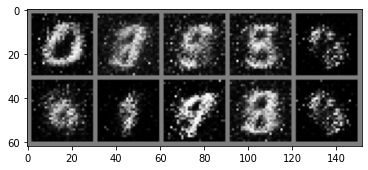

[21/50] epochs 	D loss : 0.1795 	G loss : 0.7847
[22/50] epochs 	D loss : 0.1732 	G loss : 0.7770
[23/50] epochs 	D loss : 0.1835 	G loss : 0.7656
[24/50] epochs 	D loss : 0.1863 	G loss : 0.7647
[25/50] epochs 	D loss : 0.1876 	G loss : 0.7609
[26/50] epochs 	D loss : 0.1865 	G loss : 0.7699
[27/50] epochs 	D loss : 0.1842 	G loss : 0.7728
[28/50] epochs 	D loss : 0.1995 	G loss : 0.7383
[29/50] epochs 	D loss : 0.2017 	G loss : 0.7513
[30/50] epochs 	D loss : 0.2198 	G loss : 0.7023


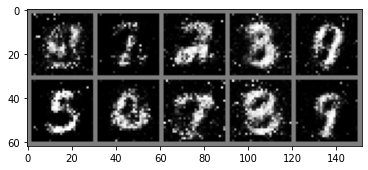

[31/50] epochs 	D loss : 0.2554 	G loss : 0.6551
[32/50] epochs 	D loss : 0.2496 	G loss : 0.6528
[33/50] epochs 	D loss : 0.2446 	G loss : 0.6565
[34/50] epochs 	D loss : 0.2630 	G loss : 0.6185
[35/50] epochs 	D loss : 0.2816 	G loss : 0.6093
[36/50] epochs 	D loss : 0.2641 	G loss : 0.6271
[37/50] epochs 	D loss : 0.2828 	G loss : 0.5893
[38/50] epochs 	D loss : 0.2643 	G loss : 0.6183
[39/50] epochs 	D loss : 0.2658 	G loss : 0.6222
[40/50] epochs 	D loss : 0.2805 	G loss : 0.5978


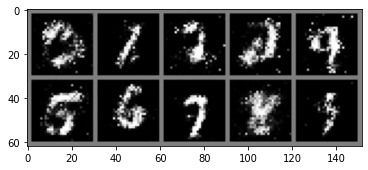

[41/50] epochs 	D loss : 0.2836 	G loss : 0.6037
[42/50] epochs 	D loss : 0.2989 	G loss : 0.5680
[43/50] epochs 	D loss : 0.3093 	G loss : 0.5611
[44/50] epochs 	D loss : 0.3028 	G loss : 0.5574
[45/50] epochs 	D loss : 0.3111 	G loss : 0.5505
[46/50] epochs 	D loss : 0.3143 	G loss : 0.5334
[47/50] epochs 	D loss : 0.3075 	G loss : 0.5562
[48/50] epochs 	D loss : 0.3078 	G loss : 0.5544
[49/50] epochs 	D loss : 0.3256 	G loss : 0.5330
[50/50] epochs 	D loss : 0.3168 	G loss : 0.5395


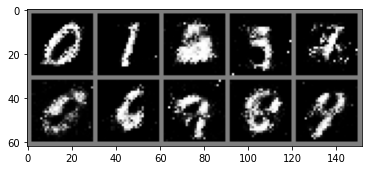

In [24]:
D.train()
G.train()
for epoch in range(epochs):
    G_losses = []
    D_losses = []

    for i, (img, label) in enumerate(loader):
        img_real, label_real = img.to(device), label.to(device)

        #=========================#
        # Descriminator training  #
        #=========================#

        batch_size = len(label)
        z = generate_noise(batch_size=batch_size).to(device)
        label_fake = torch.randint(0, 10, (batch_size,)).to(device)
        img_fake = G(z, label_fake)
        output_fake = D(img_fake, label_fake)
        output_real = D(img_real, label_real)
        
        pos_real = torch.ones(batch_size).to(device)
        pos_fake = torch.zeros(batch_size).to(device)
        
        D_loss = criterion(output_real, pos_real) + criterion(output_fake, pos_fake)
        
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        
        #======================#
        #  Generator training  #
        #======================#   

        img_fake = G(z, label_fake)
        output = D(G(z, label_fake), label_fake)
        G_loss = criterion(output, pos_real)
        
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()        
        
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())
    
    print(f'[{epoch+1}/{epochs}] epochs \tD loss : {np.array(D_losses).mean():.4f} \tG loss : {np.array(G_losses).mean():.4f}')

    if (epoch + 1) % 10 == 0:
        G.eval()
        z = generate_noise(10, 100).to(device)
        labels = torch.LongTensor(range(10)).to(device)
        output = G(z, labels)

        grid_imshow(img)
        G.train()

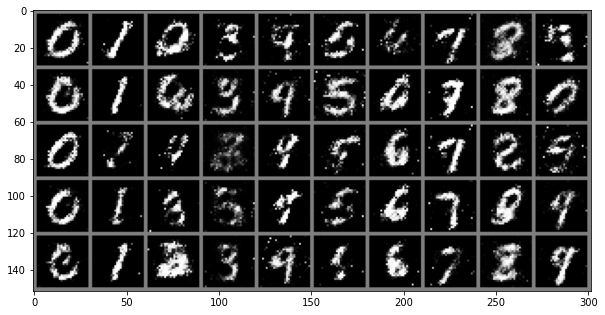

In [26]:
G.eval()
labels = torch.LongTensor([i for _ in range(5) for i in range(10)]).to(device)
z = torch.randn(len(labels), 100).to(device)
output = G(z, labels)

img = make_grid(output.cpu().detach().reshape(-1, 1, 28, 28), nrow = 10)
img = (img + 1) / 2 
np_img = img.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.show()